In [1]:
from qutip import*
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy.optimize import curve_fit
from tcsim.system import*
from tcsim.visualization import*
from tcsim.gates import*



In [2]:
# t1 = 263
# gamma_a_loss = 1 / t1  # t1 = 100mu s
# a_loss = np.sqrt(gamma_a_loss) * destroy(N)


def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))

# calculated 1D char func
def char_func_cut(state, xvec, axis = 1):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec)))
    

    for i, alpha_x in enumerate(xvec):
            expect_value = expect(displace(N, 1j*alpha_x*axis),state)
            cfReal[i] =  np.real(expect_value)

    return cfReal

def transmission (t):
    return np.exp(-t/t1)

def relative_to_t1(t):
    return t/t1

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

# find the min value of the char function, assuming the blobs are align on the X axis (works for odd cat.)
# def char_negativiy(state):
#     xvec = np.linspace(-6,6,100)
#     xcut = char_func_cut(state, xvec, 1)
#     return np.min(xcut) 
 
def lossy_channel(state, t_list, loss ):
    rhos_loss = mesolve(Ic,state, t_list, c_ops = loss).states
    return rhos_loss

def extract_amp_triple_gaussian_fit(state, bounds):
    xvec = np.linspace(-6,6,100)
    amp1 = -0.4
    sigma1 = 0.8
    cen1 = -3.5
    amp2 = 0.
    sigma2 = 1
    cen2 = 0
    amp3 = -0.4
    sigma3 = 0.9
    cen3 = 3.5
    y = char_func_cut(state, xvec)
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds = ([-1, -5, 0 ,0, -0.5, 0 ,-1, 1.8, 0], 
             [0, -1.8, 1 ,1, 0.5, 1.1 ,0, 5, 1])
    #plt.plot(xvec,y)
    popt, pcov = curve_fit(gauss_3, xvec, y, p0=initial_guess, bounds=bounds, maxfev = 5000)
    # fig, axs = plt.subplots()
    # for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
    #         axs.plot(xvec, gauss_1(xvec, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    # axs.plot(xvec, y, 'b', label="given curve")
    # axs.plot(xvec, gauss_3(xvec, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    
    # print("blob position is:", popt[1])
    # print("sigma is:", popt[2])
    return (popt[0]+popt[6])/2


def get_data(states, t_list, loss, bounds):
    blob_amps=[]
    rhos_loss_stored = []
    for i, state in enumerate(states):
        blob_amps.append([])
        rhos_loss = lossy_channel(state,t_list, loss)
        rhos_loss_stored.append(rhos_loss)
        for j, rho in enumerate(rhos_loss):
            blob_amp = extract_amp_triple_gaussian_fit(rho, bounds)
            blob_amps[i].append(blob_amp) # minus sign cause i want to take a look at the positive blobs to compare it 

            
    return blob_amps, rhos_loss_stored


def char_func_grid(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))
    N = state.dims[0][1]

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = qt.expect(qt.displace(N, alpha_x +1j*alpha_p),qt.ptrace(state,1))
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag  

def squeezingStateOneStep(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
 
    return psi1 

def squeezingStateTwoStep(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    
    
    psi1 = U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_1)*psi1
    psi3 = U_ideal_operator(u_2)*psi2
    psi4 = V_ideal_operator(v_2)*psi3
 
    return psi4

def squeezingStateThreeStep(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
    psi3 = V_ideal_operator(v_3)*U_ideal_operator(u_3)*psi2
 
    return psi3

def squeezing_loss_3uv(uvs, t1,t2):

    q_decay = np.sqrt(1 / t1) * (sx + 1j * sy) / 2
    q_dephasing = np.sqrt(1 / t2) * sz

    loss = [q_decay,q_dephasing]

    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]


    psi1 = U(vac, t_displace, t_wait, u_1, epsilon = epsilon, loss=loss)
    psi2 = V(psi1, t_displace, t_wait, v_1, epsilon = epsilon, loss=loss)
    psi3 = U(psi2, t_displace, t_wait, u_2, epsilon = epsilon, loss=loss)
    psi4 = V(psi3, t_displace, t_wait, v_2, epsilon = epsilon, loss=loss)
    psi5 = U(psi4, t_displace, t_wait, u_3, epsilon = epsilon, loss=loss)
    psi6 = V(psi5, t_displace, t_wait, v_3, epsilon = epsilon, loss=loss)
    
    return ptrace(psi6,1)
    



## check that ecd works properly

15.0


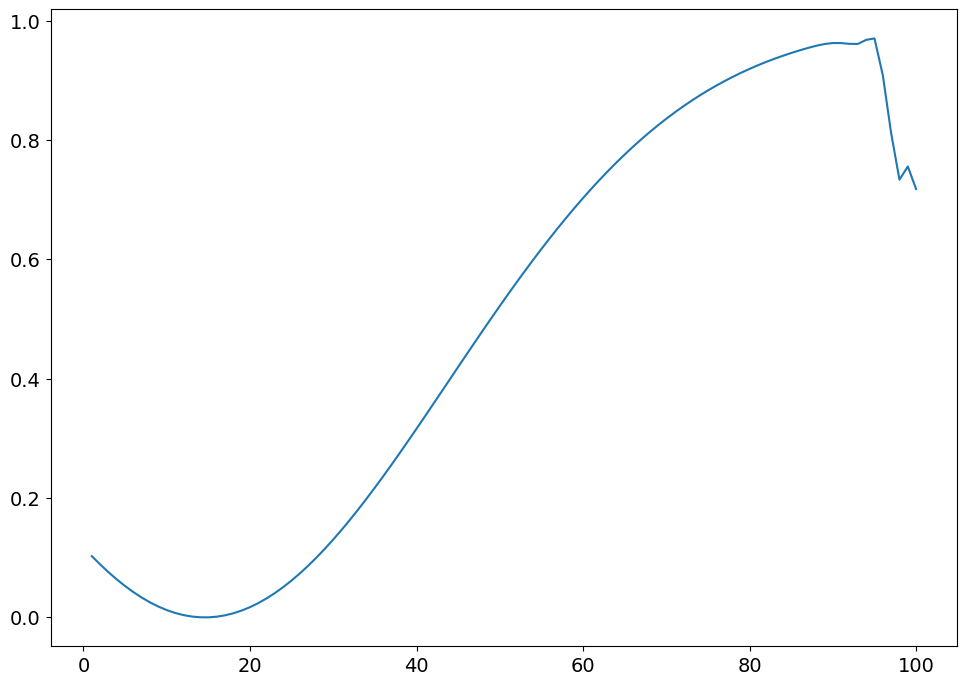

In [4]:
t_displace = np.linspace(0,0.12,10)
t_wait = np.linspace(0,0.8,10)
epsilon = 64

def overlapWithIdeal(epsilon):
    ideal  = CD_ideal_operator(1j)*vac
    exp = Rx(np.pi)*ECD_exp(vac, t_displace, t_wait, 1, epsilon = epsilon)
    overlap = exp.overlap(ideal)
    
    return 1-abs(overlap)

eps = np.linspace(1,100,100)

overlaps = []
for i in eps:
    overlaps.append(overlapWithIdeal(i))
plt.plot(eps,overlaps)
print(eps[np.argmin(overlaps)])
epsilon = eps[np.argmin(overlaps)]


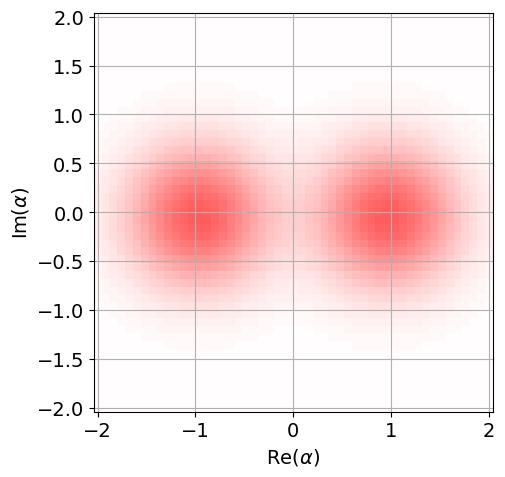

In [4]:
from tcsim.visualization import plot_wigner
psi1 = U(vac, t_displace, t_wait, 2, epsilon = epsilon)
plot_wigner(psi1)

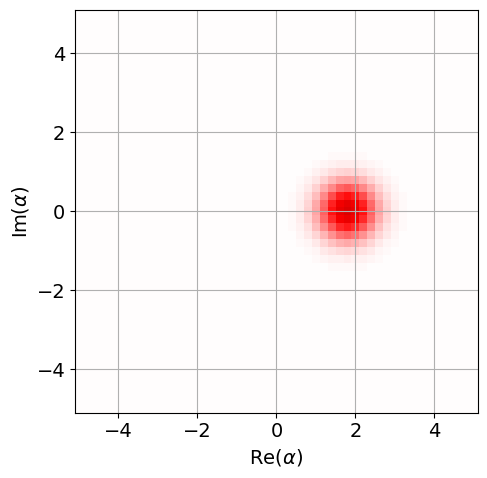

In [6]:
psi1 = D(vac, t_displace, epsilon = epsilon)
plot_wigner(psi1, max_alpha = 5)

In [5]:
### Initialize vacuum and squeezed vacuum states via hastrup
uvs = [[ 1.38744578,  0.51199234, -0.19874056, -0.46461027, -0.3244084,  -0.65943663],
    [ 1.62946677,  0.39181981, -0.48019506, -1.04030892, -1.10939512,
        0.32484321],
    [-0.83900019,  0.56644014,  1.2973754 , -0.59798946, -1.26378237,
        0.38608659]
    
    
 ]


qu_t1 = np.inf
qu_t2 = 20
states = [ket2dm(fock(N,0))]
for uv in uvs:
    states.append(squeezing_loss_3uv(uv, qu_t1,qu_t2))

### turn them into the according cat states
### in experiment, we displaced the states as if they were ideal squeezed states. Its only fair to do the same here if we want to compare the two.
alphas =[1.8,1.2743, 0.902, 0.804]
cats = []
for i, state in enumerate(states):
    cat = ((displace(N,1j*alphas[i]) - displace(N, -1j*alphas[i]))*state*(displace(N,1j*alphas[i]) - displace(N, -1j*alphas[i])).dag()).unit()
    cats.append(cat)





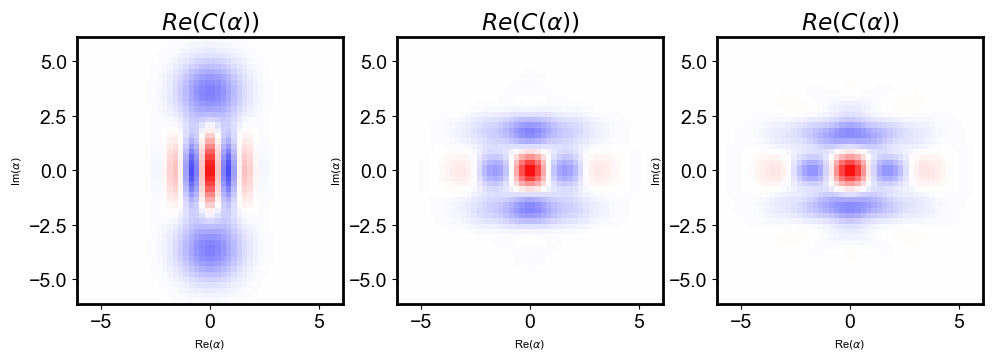

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [42]:
fig, axs = plt.subplots(1,len(states))
for i, cat in enumerate(cats):
    plot_char(tensor(fock(2,0)*fock(2,0).dag(),cats[i]),max_alpha = 6, ax = axs[i])

In [6]:
a = destroy(N)
t1 = np.inf
t2 = np.inf
gamma_a_loss = 1 / t1  # t1 = 100mu s
gamma_dephasing = 1/ t2
a_loss = np.sqrt(gamma_a_loss) * destroy(N)
a_dephasing = np.sqrt(gamma_dephasing) * (a * a.dag() + a.dag() * a)
loss = [a_loss, a_dephasing]
# time evolution span
ts = np.linspace(0,200,10)
#ts = np.linspace(0,200, 15) # values are chosen such that we are between transmission of 0.5 (70) and 1 (0.1)

# get the wigner negativity of the state for each point in time
#blob_amps, rhos = get_data(cats[1], ts)

bounds =[([-1, -5, 0 ,0, -0.5, 0 ,-1, 1.8, 0], 
             [0, -1.8, 1 ,1, 0.5, 1.1 ,0, 5, 1]), ([-1, -5, 0 ,0, -0.5, 0 ,-1, 1.8, 0],
    [-1, -5, 0 ,0, -0.5, 0 ,-1, 1.8, 0], 
             [0, -1.8, 1 ,1, 0.5, 1.1 ,0, 5, 1]), ([-1, -5, 0 ,0, -0.5, 0 ,-1, 1.8, 0], 
             [0, -1.8, 1 ,1, 0.5, 1.1 ,0, 5, 1]),([-1, -5, 0 ,0, -0.5, 0 ,-1, 1.8, 0], 
             [0, -1.8, 1 ,1, 0.5, 1.1 ,0, 5, 1])] 

# rhos_loss = lossy_channel(cats[0],ts, loss = loss)
# blob_amps = []
# for j, rho in enumerate(rhos_loss):
#     blob_amps.append( extract_amp_triple_gaussian_fit(rho, bounds))

blob_amps, rhos = get_data(cats, ts, loss, bounds= bounds)

# use to plot the negativity vs "transmission" exp(-t/T1)
transmis = []
for i in ts:
    transmis.append(transmission(i))

# calculate points in time as fraction of T1 
rel_t1 = []
for i in ts:
    rel_t1.append(relative_to_t1(i))

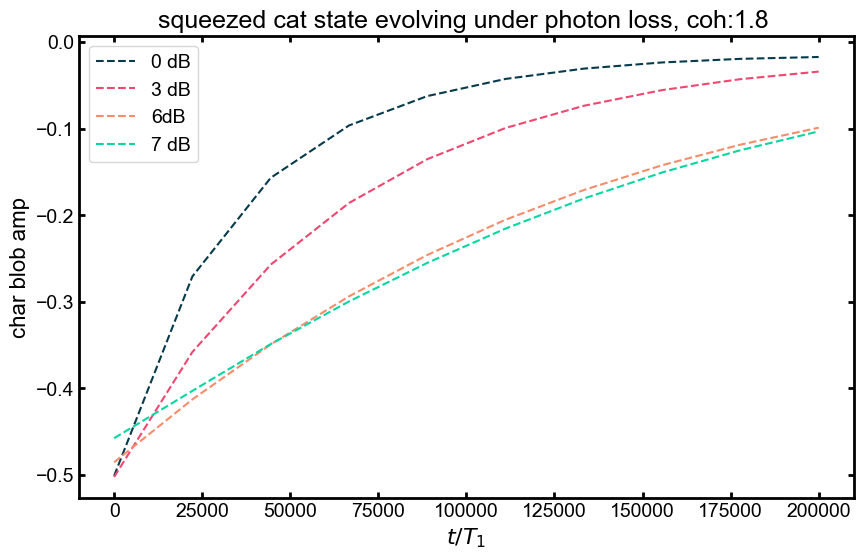

In [8]:
import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();
times = np.array(ts)*1e3
#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(times,blob_amps[0], '--', color = '#073B4C', label = '0 dB')
ax.plot(times,blob_amps[1], '--', color = '#ef476f', label = '3 dB')
ax.plot(times,blob_amps[2], '--', color = '#f78c6b',label = '6dB')
ax.plot(times,blob_amps[3], '--', color = '#06d6a0',label = '7 dB')
# ax.plot(times,blob_amps[3], '--', color = '#118ab2',label = '7.1 dB')
#ax.plot(rel_t1,negativity_loss[4], '>', color = '#073b4c',label = '12 dB')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
# ax.plot(rel_t1,negativity_loss2[5], '--v', color = '#118ab2',label = '10 dB')

ax.set_xlim()

ax.set_title(f"squeezed cat state evolving under photon loss, coh:1.8 ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()


In [7]:
bootstrap_data = np.load("bootstrap_data.npy")


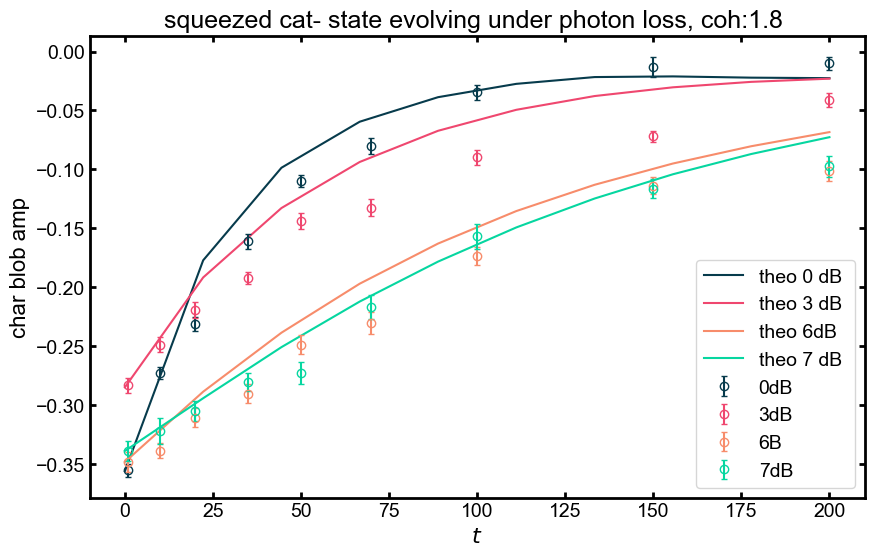

In [16]:
# scaling with exp data amplitudes
import matplotlib as mpl
vac_scale = 0.883
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();
times = np.array(ts)
# plot theory
ax.plot(times,np.array(blob_amps[0])*-2*bootstrap_data[0,0][0]/vac_scale, color = '#073B4C', label = 'theo 0 dB ')
ax.plot(times,np.array(blob_amps[1])*-2*bootstrap_data[0,1][0]/vac_scale,  label = 'theo 3 dB ', color = '#ef476f' )
ax.plot(times,np.array(blob_amps[2]/(-2*blob_amps[2][0]))*-2*bootstrap_data[0,2][0]/vac_scale, color = '#f78c6b',label = 'theo 6dB')
ax.plot(times,np.array(blob_amps[3]/(-2*blob_amps[3][0]))*-2*bootstrap_data[0,3][0]/vac_scale, color = '#06d6a0',label = 'theo 7 dB')

decay_times = np.array([  1000.,  10000.,  20000.,  35000.,  50000.,  70000., 100000.,
       150000., 200000.])*1e-3
# plot experiment
ax.errorbar(decay_times[:], bootstrap_data[0,0]/vac_scale,yerr=bootstrap_data[1,0],fmt= 'o',markerfacecolor='none', label = '0dB', capsize = 2, color = '#073B4C',)
ax.errorbar(decay_times[:], bootstrap_data[0,1]/vac_scale,yerr=bootstrap_data[1,1],fmt= 'o',markerfacecolor='none', label = '3dB', capsize = 2,color = '#ef476f')
ax.errorbar(decay_times[:], bootstrap_data[0,2]/vac_scale,yerr=bootstrap_data[1,2],fmt= 'o',markerfacecolor='none', label = '6B', capsize = 2, color = '#f78c6b',)
ax.errorbar(decay_times[:], bootstrap_data[0,3]/vac_scale,yerr=bootstrap_data[1,3],fmt= 'o',markerfacecolor='none', label = '7dB', capsize = 2, color = '#06d6a0',)

ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:1.8 ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()


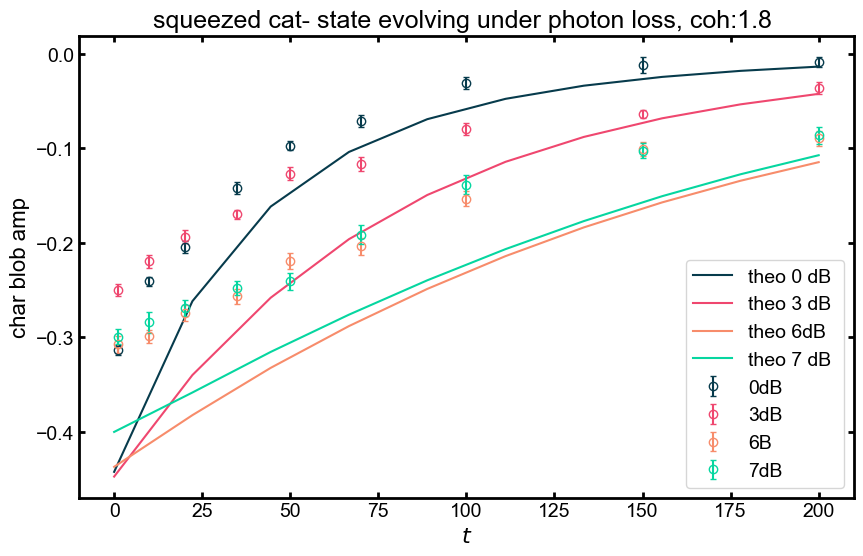

In [75]:
import matplotlib as mpl
vac_scale = 0.883
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();
times = np.array(ts)
# plot theory
ax.plot(times,np.array(blob_amps[0])*vac_scale, color = '#073B4C', label = 'theo 0 dB ')
ax.plot(times,np.array(blob_amps[1])*vac_scale, label = 'theo 3 dB ', color = '#ef476f' )
ax.plot(times,np.array(blob_amps[2])*vac_scale, color = '#f78c6b',label = 'theo 6dB')
ax.plot(times,np.array(blob_amps[3])*vac_scale, color = '#06d6a0',label = 'theo 7 dB')

decay_times = np.array([  1000.,  10000.,  20000.,  35000.,  50000.,  70000., 100000.,
       150000., 200000.])*1e-3
# plot experiment
ax.errorbar(decay_times[:], bootstrap_data[0,0],yerr=bootstrap_data[1,0],fmt= 'o', markerfacecolor='none',label = '0dB', capsize = 2, color = '#073B4C')
ax.errorbar(decay_times[:], bootstrap_data[0,1],yerr=bootstrap_data[1,1],fmt= 'o', markerfacecolor='none', label = '3dB', capsize = 2,color = '#ef476f')
ax.errorbar(decay_times[:], bootstrap_data[0,2],yerr=bootstrap_data[1,2],fmt= 'o',markerfacecolor='none', label = '6B', capsize = 2, color = '#f78c6b',)
ax.errorbar(decay_times[:], bootstrap_data[0,3],yerr=bootstrap_data[1,3],fmt= 'o',markerfacecolor='none', label = '7dB', capsize = 2, color = '#06d6a0',)

ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:1.8 ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()


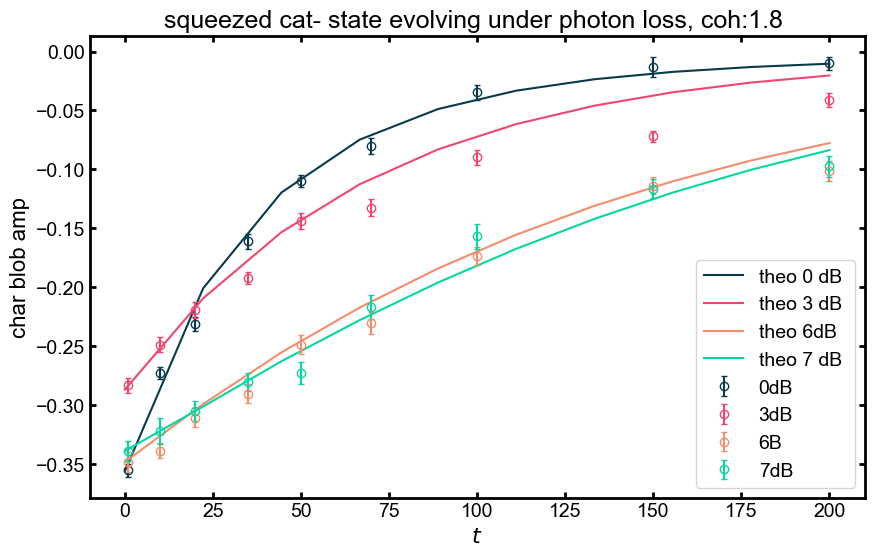

In [88]:
# scaling with exp data amplitudes
import matplotlib as mpl
vac_scale = 0.883
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();
times = np.array(ts)
# plot theory
ax.plot(times,np.array(blob_amps[0])*-2*bootstrap_data[0,0][0]/vac_scale, color = '#073B4C', label = 'theo 0 dB ')
ax.plot(times,np.array(blob_amps[1])*-2*bootstrap_data[0,1][0]/vac_scale,  label = 'theo 3 dB ', color = '#ef476f' )
ax.plot(times,np.array(blob_amps[2]/(-2*blob_amps[2][0]))*-2*bootstrap_data[0,2][0]/vac_scale, color = '#f78c6b',label = 'theo 6dB')
ax.plot(times,np.array(blob_amps[3]/(-2*blob_amps[3][0]))*-2*bootstrap_data[0,3][0]/vac_scale, color = '#06d6a0',label = 'theo 7 dB')

decay_times = np.array([  1000.,  10000.,  20000.,  35000.,  50000.,  70000., 100000.,
       150000., 200000.])*1e-3
# plot experiment
ax.errorbar(decay_times[:], bootstrap_data[0,0]/vac_scale,yerr=bootstrap_data[1,0],fmt= 'o',markerfacecolor='none', label = '0dB', capsize = 2, color = '#073B4C',)
ax.errorbar(decay_times[:], bootstrap_data[0,1]/vac_scale,yerr=bootstrap_data[1,1],fmt= 'o',markerfacecolor='none', label = '3dB', capsize = 2,color = '#ef476f')
ax.errorbar(decay_times[:], bootstrap_data[0,2]/vac_scale,yerr=bootstrap_data[1,2],fmt= 'o',markerfacecolor='none', label = '6B', capsize = 2, color = '#f78c6b',)
ax.errorbar(decay_times[:], bootstrap_data[0,3]/vac_scale,yerr=bootstrap_data[1,3],fmt= 'o',markerfacecolor='none', label = '7dB', capsize = 2, color = '#06d6a0',)

ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:1.8 ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()


In [90]:
times

array([  0.        ,  22.22222222,  44.44444444,  66.66666667,
        88.88888889, 111.11111111, 133.33333333, 155.55555556,
       177.77777778, 200.        ])

In [95]:
np.savez("theo_curves", blob_amps = blob_amps, times = times)

# Ideal squeezed states

In [10]:
### States
alpha = 1.8
cat = (coherent(N,1j*alpha) - coherent(N,-1j*alpha)).unit()

dBs = [0, 3, 6, 7] # extracted from vacuum blobs.

# first cat, then squeeze
states = [squeeze(N,calc_squeez_parameter(np.exp(1j*np.pi)*i))for i in dBs]*cat

t1 = 263 # taken from data
gamma_a_loss = 1 / t1  
a_loss = np.sqrt(gamma_a_loss) * destroy(N)

[-5.00768083e-01 -3.60000000e+00 -1.00000000e+00  1.00153617e+00
  1.16865155e-15  1.00000000e+00 -5.00768083e-01  3.60000000e+00
 -1.00000000e+00]


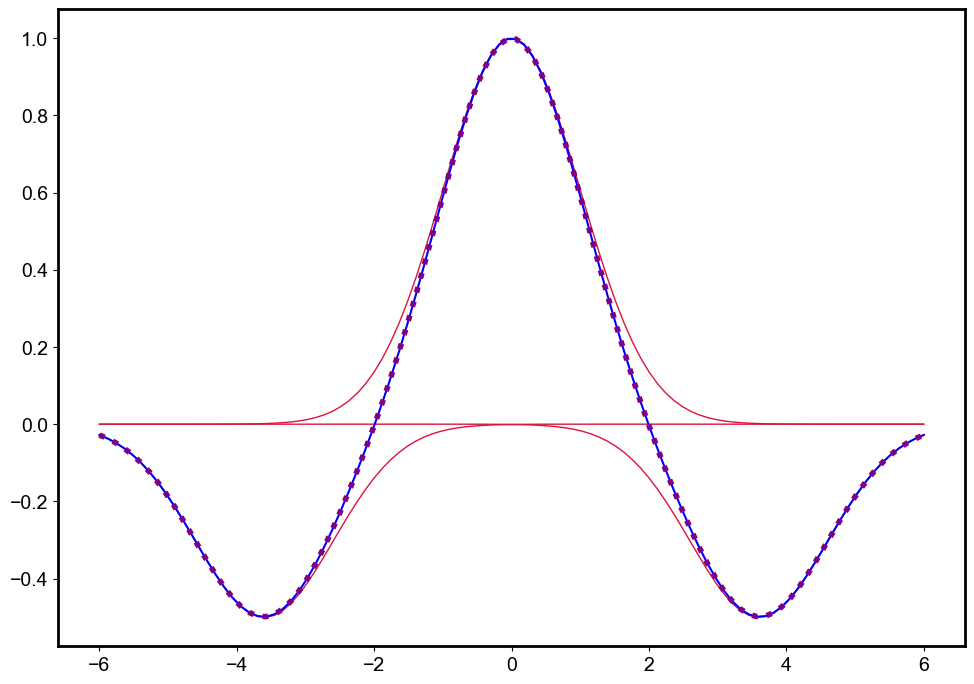

In [13]:
# check that the fitting works.
t1 = 263
gamma_a_loss = 1 / t1  # t1 = 100mu s
a_loss = np.sqrt(gamma_a_loss) * destroy(N)
ts = [     1,  10,  16,  30,  50,  70, 100,
       150, 200]
#ts = np.linspace(0,120, 30) 
rhos_loss = lossy_channel(states[0], ts, loss = a_loss)

# check that the fit works
fig, axs = plt.subplots()

amp1 = 0.3
sigma1 = 1
cen1 = -2
amp2 = 0.8
sigma2 = 1
cen2 = 0
amp3 = 0.3
sigma3 = 1
cen3 = 2
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
bounds = ([-np.inf, -np.inf, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, -np.inf, -np.inf ],[np.inf, np.inf, 1.2,np.inf, np.inf, 1.2,np.inf, np.inf, 1.1 ]) 
    
    
xvec = np.linspace(-6,6, 100)
cut = char_func_cut(rhos_loss[0],xvec)


popt, pcov = curve_fit(gauss_3, xvec, cut, p0=initial_guess, bounds=bounds)

for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs.plot(xvec, gauss_1(xvec, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
axs.plot(xvec, cut, 'b', label="given curve")
axs.plot(xvec, gauss_3(xvec, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
print(popt)

In [20]:
bounds = ([-1, -5, 0 ,0, -0.5, 0 ,-1, 1.8, 0], 
             [0, -1.8, 1 ,1, 0.5, 1.1 ,0, 5, 1])

# time evolution span
ts = [     1,  10,  16,  30,  50,  70, 100,
       150, 200]


# get the wigner negativity of the state for each point in time
blob_amps_ideal, rhos = get_data(states, ts, loss = loss, bounds = bounds)


# use to plot the negativity vs "transmission" exp(-t/T1)
transmis = []
for i in ts:
    transmis.append(transmission(i))

# calculate points in time as fraction of T1 
rel_t1 = []
for i in ts:
    rel_t1.append(relative_to_t1(i))

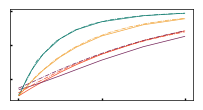

In [51]:
import matplotlib as mpl


cm = 1.0/2.54  # centimeters in inches

mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['boxplot.flierprops.markersize'] = 1
mpl.rcParams['figure.figsize'] = [6*cm, 3*cm]
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.size'] = 1.5
mpl.rcParams['ytick.major.size'] = 1.5
mpl.rcParams['xtick.minor.size'] = 1.5
mpl.rcParams['ytick.minor.size'] = 1.5
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.major.top'] = False
mpl.rcParams['xtick.major.bottom'] = True
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['ytick.direction'] = 'in'


colours = [([0.07, 0.49, 0.44]),
 ([0.95, 0.65, 0.23]),
 ([0.95, 0.29, 0.14]),
 ([0.45, 0.13, 0.34]),
 ([0.13, 0.13, 0.26])]

fig, ax = plt.subplots()

#ax.grid();
times = np.array(ts)
#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(times,blob_amps_ideal[0], color = colours[0], label = '0 dB')
ax.plot(times,blob_amps_ideal[1],  color = colours[1],label = '3 dB' )
ax.plot(times,blob_amps_ideal[2],  color = colours[2],label = '6 dB')
ax.plot(times,blob_amps_ideal[3],  color = colours[3],label = '7 dB')
#ax.plot(rel_t1,negativity_loss[4], '>', color = '#073b4c',label = '12 dB')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
# ax.plot(rel_t1,negativity_loss2[5], '--v', color = '#118ab2',label = '10 dB')
times  = np.linspace(0,200,10)
ax.plot(times,blob_amps[0], '-.', color = colours[0])
ax.plot(times,blob_amps[1], '-.', color = colours[1])
ax.plot(times,blob_amps[2], '-.', color = colours[2])
ax.plot(times,blob_amps[3], '-.', color = colours[3])


fig.savefig("ideal_vs_hastrup_timedynamics.pdf")


In [ ]:
ax.plot(times,blob_amps[0], '--', color = '#073B4C', label = '0 dB')
ax.plot(times,blob_amps[1], '--', color = '#ef476f', label = '3 dB')
ax.plot(times,blob_amps[2], '--', color = '#f78c6b',label = '6dB')
ax.plot(times,blob_amps[3], '--', color = '#06d6a0',label = '7 dB')

## Compare theory and approximate squeezed vacuum

ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

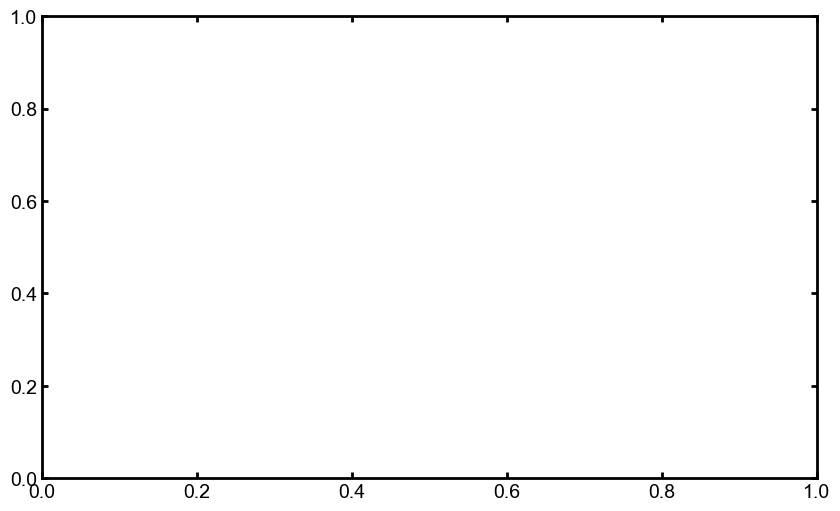

In [24]:
import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();
times = np.array(ts)*1e3
#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(times,blob_amps[0], '--', color = '#ef476f', label = '0 dB Hastrup')
ax.plot(times,blob_amps[1], '--', color = '#f78c6b',label = '2 dB Hastrup')
ax.plot(times,blob_amps[2], '--', color = '#06d6a0',label = '4.8 dB Hastrup')
ax.plot(times,blob_amps[3], '--', color = '#118ab2',label = '7.1 dB Hastrup')

times  = np.linspace(0,200,10)
ax.plot(times,blob_amps_ideal[0], '>', color = '#ef476f', label = '0 ideal dB')
ax.plot(times,blob_amps_ideal[1], '<', color = '#f78c6b',label = '2 ideal dB')
ax.plot(times,blob_amps_ideal[2], '*', color = '#06d6a0',label = '4.8 ideal dB')
ax.plot(times,blob_amps_ideal[3], '+', color = '#118ab2',label = '7.1 ideal dB')
#ax.plot(rel_t1,negativity_loss[4], '>', color = '#073b4c',label = '12 dB')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
# ax.plot(rel_t1,negativity_loss2[5], '--v', color = '#118ab2',label = '10 dB')

ax.set_xlim()

ax.set_title(f"squeezed cat+ state evolving under photon loss, coh:1.8 ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()


In [56]:
np.save("blob_amps_ideal", arr = blob_amps_ideal)

In [17]:
bounds

([-inf, -inf, -inf, -inf, -inf, -0.9, -inf, -inf, -inf],
 [inf, inf, 1.2, inf, inf, 1.2, inf, inf, 1.1])